# Experiments on Graph-Generative-Models
In this notebook, we aim to evluate the performance of "GDSS" proposed in "Score-based Generative Modeling of Graphs via the System of Stochastic Differential Equations" (https://arxiv.org/pdf/2202.02514.pdf). The baseline model is tested on 3 datasets (Grid, Protein, 3D Point Cloud) and measured under 4 metrics (degree, clustering, orbit, spectral).

It should be noted that we adopt the same datasets presets as in "Efficient Graph Generation with Graph Recurrent Attention Networks" (https://arxiv.org/pdf/1910.00760.pdf), where:
- Grid: 100 graphs are generated with $100\leq |V| \leq 400$;
- Protein: 918 graphs are generated with $100\leq |V| \leq 500$;
- 3D Point-Cloud (FirstMM-DB): 41 graphs are generated with $\bar{|V|} > 1000$

Following the experimental setting as in "GraphRNN: Generating Realistic Graphs with Deep Auto-regressive Models" (https://arxiv.org/abs/1802.08773), we conduct a 80\%-20\% split of the graph samples in each dataset. Then we generate the same size of graph samples as the test dataset and harness the maximum mean discrepancy (MMD) to evaluate the generative graph distribution.

### Experiment on GDSS
Here we immigrate the original terminal-executable GDSS codes into the notebook.

##### Change current directory.

In [1]:
import os
path = "./GDSS_o/"
os.chdir(path)

##### Install dependencies

In [ ]:
%pip install -r requirements.txt
%conda install -c conda-forge rdkit=2020.09.1.0
!yes | pip install git+https://github.com/fabriziocosta/EDeN.git --user!

##### Assign dataset and seed

In [2]:
dataset = 'grid'
dataset = 'DD'
dataset = 'community_small'
dataset = 'caveman'
# dataset = 'FIRSTMM_DB'
seed = 42

##### Clear cache

In [3]:
%pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()                           

Note: you may need to restart the kernel to use updated packages.


/nethome/hsun409/anaconda3/envs/GDSS_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 26% | 65% |
|  1 |  1% | 82% |
|  2 | 13% | 43% |
|  3 |  7% | 60% |
|  4 |  6% | 62% |
|  5 |  6% | 89% |
|  6 |  0% | 90% |
|  7 |  0% | 95% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  0% | 66% |
|  1 |  0% | 82% |
|  2 |  0% | 43% |
|  3 |  6% | 60% |
|  4 |  5% | 62% |
|  5 |  1% | 89% |
|  6 |  0% | 90% |
|  7 |  0% | 95% |


##### Generate dataset

In [4]:
!python data/data_generators.py --dataset $dataset

Loading graph dataset: FIRSTMM_DB
56468
126038
Graphs loaded, total num: 24
FIRSTMM_DB 24
995


##### Train the GDSS model

In [ ]:
import torch
import argparse
import time
from parsers.config import get_config
from trainer import Trainer

os.environ["CUDA_VISIBLE_DEVICES"] = "6,7"
torch.cuda.empty_cache()

ts = time.strftime('%b%d-%H:%M:%S', time.gmtime())
config = get_config(dataset, seed)
trainer = Trainer(config) 
ckpt = trainer.train(ts)
if 'sample' in config.keys():
    config.ckpt = ckpt
    sampler = Sampler(config) 
    sampler.sample()

##### Generate new graphs by the trained GDSS model

In [1]:
import os
path = "./GDSS_o/"
os.chdir(path)
os.environ["CUDA_VISIBLE_DEVICES"] = "0,2,3,4,5"

import torch
import argparse
import time
from parsers.config import get_config
from trainer import Trainer
from sampler import Sampler, Sampler_mol
from evaluation.stats import eval_graph_list
from evaluation.mmd import gaussian, gaussian_emd
from data.data_generators import load_dataset

torch.cuda.empty_cache()

# dataset = 'caveman'
# dataset = 'cora'
# dataset = 'community_small'
# dataset = 'breast'
# dataset = 'grid'

datasets = ['caveman', 'cora', 'breast']


# ckpt = 'caveman_5000'
# ckpt = 'cora_5000'
# ckpt = 'gdss_community_small'
# ckpt = 'gdss_grid'
ckpts = ['caveman_5000', 'cora_5000', 'breast_5000']
ckpts = ['caveman_5000']
seed = 42
test_split = 0.2

GEN_seeds = [11,12,13,14,15]
GEN_seeds = [13]
for gen_seed in GEN_seeds:
    for dataset, ckpt in zip(datasets, ckpts):
        # if dataset == 'caveman' and gen_seed == 13:
        #     continue
        # if dataset == 'cora' and gen_seed == 12:
        #     continue
        # if dataset == 'breast' and gen_seed == 13:
        #     continue
        print(gen_seed, dataset, ckpt)
        graph_list = load_dataset(data_dir='data', file_name=dataset)
        if dataset == 'cora':
            print('for cora, only take first 200 samples')
            graph_list = graph_list[:200].copy()
        test_size = int(test_split * len(graph_list))
        print('Test size:', test_size)

        config = get_config(dataset, seed)
        config.sample.seed = gen_seed
        config.ckpt = ckpt
        sampler = Sampler(config) 
        sampler.sample()

13 caveman caveman_5000
Test size: 40
./checkpoints/caveman/caveman_5000.pth loaded
----------------------------------------------------------------------------------------------------
Make Directory caveman/test in Logs
caveman_5000-sample20:05:40
caveman_5000-sample20:05:40
----------------------------------------------------------------------------------------------------
[caveman]   init=deg (10)   seed=42   batch_size=128
----------------------------------------------------------------------------------------------------
lr=0.01 schedule=True ema=0.999 epochs=5000 reduce=False eps=1e-05
(ScoreNetworkX)+(ScoreNetworkA=GCN,4)   : depth=3 adim=32 nhid=32 layers=5 linears=2 c=(2 8 4)
(x:VP)=(0.10, 1.00) N=1000 (adj:VP)=(0.10, 1.00) N=1000
----------------------------------------------------------------------------------------------------
(Euler)+(Langevin): eps=0.0001 denoise=True ema=False || snr=0.05 seps=0.7 n_steps=1 
---------------------------------------------------------------

 
Round 0 : 583.04s


 
Round 1 : 591.05s


 
Round 2 : 580.44s


 
Round 3 : 576.11s


 
Round 4 : 584.50s


 
Round 5 : 588.54s


 
Round 6 : 591.70s


 
Round 7 : 574.78s
degree    : 0.008862
cluster   : 0.032990
orbit     : 0.002116


1000
[7.3999999999999995]
7.3999999999999995


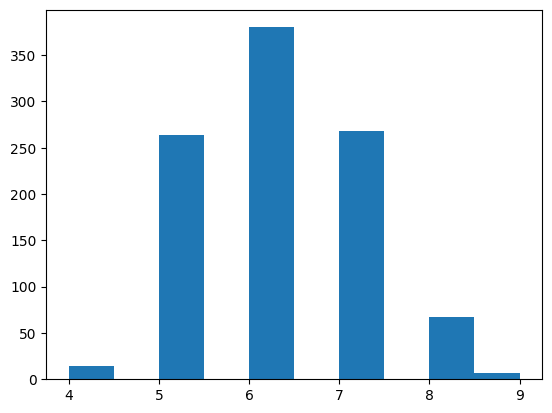

In [1]:
import pickle
import networkx as nx
import os
import numpy as np
import matplotlib.pyplot as plt

path = "./GDSS_o/"
os.chdir(path)

# caveman_filenames = ['caveman_5000-sample18:20:01','caveman_5000-sample18:31:34', 
#                     'caveman_5000-sample18:42:56', 'caveman_5000-sample18:54:07', 'caveman_5000-sample19:05:19']
caveman_filenames = ['caveman_5000-sample20:05:40']
max_degree = 7
percentage_per_seed = []
for caveman_file in caveman_filenames:
    save_dir = './samples/pkl/caveman/test/' + caveman_file + '.pkl'
    max_degree_list = []
    with open(save_dir, 'rb') as f:
        graph_list = pickle.load(f)
    print(len(graph_list))
    for g in graph_list:
        max_degree_list.append(max([deg[1] for deg in g.degree()]))
    count = sum(deg > max_degree for deg in max_degree_list)
    percentage_per_seed.append(count / len(max_degree_list)*100)
print(percentage_per_seed)
print(np.mean(percentage_per_seed))
plt.hist(max_degree_list)
plt.show()

In [10]:
import numpy as np

caveman_data = np.array(   [[0.052101, 0.035703, 0.008728, 0.052592, 543.10],
                            [0.009252, 0.052657, 0.011149, 0.054503, 567.02],
                            [0.013782, 0.096422, 0.003810, 0.053426, 514.05],
                            [0.008394, 0.025967, 0.001613, 0.052327, 541.94],
                            [0.009951, 0.030907, 0.006007, 0.051819, 567.91]])
cora_data = np.array(      [[0.142844, 0.364501, 0.179599, 0.055982, 384.09],
                            [0.171458, 0.359900, 0.192201, 0.056620, 421.69],
                            [0.155826, 0.411962, 0.185434, 0.057684, 414.47],
                            [0.158801, 0.292940, 0.186371, 0.054138, 415.15],
                            [0.175053, 0.452426, 0.193078, 0.055921, 416.62]])
breast_data = np.array(    [[0.111363, 0.026105, 0.000992, 0.120782, 788.48],
                            [0.100157, 0.012885, 0.002211, 0.120369, 813.11],
                            [0.111881, 0.019623, 0.003031, 0.120421, 858.41],
                            [0.115581, 0.005944, 0.001996, 0.120318, 818.76],
                            [0.125758, 0.014162, 0.001254, 0.119872, 825.96]])
with np.printoptions(precision=6, suppress=True, formatter={'float': '{: .6f}'.format}):
    print(np.mean(caveman_data, axis=0))
    print(np.mean(cora_data, axis=0))
    print(np.mean(breast_data, axis=0))
    print(np.std(caveman_data, axis=0))
    print(np.std(cora_data, axis=0))
    print(np.std(breast_data, axis=0))

[ 0.018696  0.048331  0.006261  0.052933  546.804000]
[ 0.160796  0.376346  0.187337  0.056069  410.404000]
[ 0.112948  0.015744  0.001897  0.120352  820.944000]
[ 0.016804  0.025670  0.003396  0.000942  19.820961]
[ 0.011558  0.053710  0.004920  0.001155  13.397731]
[ 0.008225  0.006769  0.000725  0.000290  22.578371]


##### Decide which metric to be used

In [1]:
import os
path = "./GDSS/"
os.chdir(path)

seed = 42
dataset = 'grid'
# dataset = 'community_small'
# dataset = 'caveman'
# dataset = 'cora'
# dataset = 'breast'

metric_selection = 'EMD'

if metric_selection == 'EMD':
    from sampler import Sampler, Sampler_mol
    from evaluation.stats import eval_graph_list
    from evaluation.mmd import gaussian, gaussian_emd
else:
    from sampler_new import Sampler, Sampler_mol
    from evaluation.stats_new import eval_graph_list
    import evaluation.mmd_new

/nethome/hsun409/anaconda3/envs/GDSS_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Load and calculate the metrics

In [2]:
import pickle
import math

from utils.logger import Logger, set_log, start_log, train_log, sample_log, check_log
from data.data_generators import load_dataset

# save_dir = '../GDSS_o/samples/pkl/caveman/test/caveman_5000-sample.pkl'
# save_dir = '../GDSS_o/samples/pkl/cora/test/cora_5000-sample.pkl'
# save_dir = '../GDSS_o/samples/pkl/community_small/test/gdss_community_small-sample.pkl'
# save_dir = '../GDSS_o/samples/pkl/breast/test/breast_5000-sample.pkl'

with open(save_dir, 'rb') as f:
    gen_graph_list = pickle.load(f)

test_split = 0.2

graph_list = load_dataset(data_dir='../GDSS_o/data', file_name=dataset)
print('Target dataset:' + dataset)
if dataset == 'cora':
    print('for cora, only take first 200 samples')
    graph_list = graph_list[:200].copy()
test_size = int(test_split * len(graph_list))
train_size = len(graph_list) - test_size
train_graph_list, test_graph_list = graph_list[:train_size], graph_list[train_size:]
# train_graph_list, test_graph_list = graph_list[test_size:], graph_list[:test_size]
print('Length of testing dataset:' + str(len(test_graph_list)))
print('Length of gen dataset:' + str(len(gen_graph_list)))
methods = ['degree', 'cluster', 'orbit', 'spectral'] 
kernels = {}
if metric_selection == 'EMD':
    kernels = {'degree':gaussian_emd, 
                'cluster':gaussian_emd, 
                'orbit':gaussian,
                'spectral':gaussian_emd}
    result_dict = eval_graph_list(test_graph_list, gen_graph_list, methods, kernels)
else:
    result_dict = eval_graph_list(test_graph_list, gen_graph_list)

Target dataset:grid
Length of testing dataset:20
Length of gen dataset:20
degree    : 0.056618
cluster   : 0.011350
orbit     : 0.254204
spectral  : 1.046698


##### Plot graphs

In [ ]:
from utils.plot import plot_graphs_list

for idx, g in enumerate(gen_graph_list):
    print(idx, g)

# plot_graphs_list(graphs=gen_graph_list, title=dataset, max_num=16, save_dir=dataset)

### Experiment on GraphAF/GraphDF
Here we investigate the likelihood on GraphAF/GraphDF. Since they are autoreggressive models, their likelihoods can be derived directly by extracting the loss functions.

##### Installations

In [ ]:
import torch; print(torch.__version__)
import torch; print(torch.version.cuda)
CUDA = 'cu116'
TORCH = '1.12.1'
%pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cu116.html
%pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cu116.html
%pip install torch-geometric
%pip install torch-cluster -f https://data.pyg.org/whl/torch-1.12.1+cu116.html
%pip install torch-spline-conv -f https://data.pyg.org/whl/torch-1.12.1+cu116.html
%pip install dive-into-graphs

import torch_geometric; print(torch_geometric.__version__)
from dig.version import __version__; print(__version__)

##### Load dataset 1

In [1]:
from lib2to3.pytree import Node
import pickle
import networkx as nx
from torch.utils.data import Dataset, DataLoader
from scipy.sparse import csr_matrix
import numpy as np
import math

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4"
import torch


def calc_max_prev_node_helper(idx, graphs_path):
    with open(graphs_path + 'graph' + str(idx) + '.dat', 'rb') as f:
        G = pickle.load(f)

    max_prev_node = []
    for _ in range(100):
        bfs_seq, _ = get_random_bfs_seq(G)
        bfs_order_map = {bfs_seq[i]: i for i in range(len(G.nodes()))}
        G = nx.relabel_nodes(G, bfs_order_map)

        max_prev_node_iter = 0
        for u, v in G.edges():
            max_prev_node_iter = max(max_prev_node_iter, max(u, v) - min(u, v))

        max_prev_node.append(max_prev_node_iter)

    return max_prev_node


def calc_max_prev_node(graphs_path):
    """
    Approximate max_prev_node from simulating bfs sequences 
    """
    max_prev_node = []
    count = len([name for name in os.listdir(
        graphs_path) if name.endswith(".dat")])

    max_prev_node = []
    with Pool(processes=8) as pool:
        for max_prev_node_g in tqdm(pool.imap_unordered(
                partial(calc_max_prev_node_helper, graphs_path=graphs_path), list(range(count)))):
            max_prev_node.extend(max_prev_node_g)

    max_prev_node = sorted(max_prev_node)[-1 * int(0.001 * len(max_prev_node))]
    return max_prev_node

def get_bfs_seq(G, start_id):
    """
    Get a bfs node sequence
    :param G: graph
    :param start_id: starting node
    :return: List of bfs node sequence
    """
    successors_dict = dict(nx.bfs_successors(G, start_id))
    start = [start_id]
    output = [start_id]
    while len(start) > 0:
        succ = []
        for current in start:
            if current in successors_dict:
                succ = succ + successors_dict[current]

        output = output + succ
        start = succ
    return output

def get_random_bfs_seq(graph):
    n = len(graph.nodes())
    # Create a random permutaion of graph nodes
    perm = torch.randperm(n)
    adj = nx.to_numpy_matrix(graph, nodelist=perm.numpy().tolist(), dtype=int)
    G = nx.from_numpy_matrix(adj)
    # Construct bfs ordering starting from a random node
    start_id = 0
    bfs_seq = get_bfs_seq(G, start_id)
    return [perm[bfs_seq[i]] for i in range(n)], perm

# load a list of graphs
def load_graph_list(fname,is_real=True):
    with open(fname, "rb") as f:
        graph_list = pickle.load(f)
    for i in range(len(graph_list)):
        edges_with_selfloops = graph_list[i].selfloop_edges()
        if len(edges_with_selfloops)>0:
            graph_list[i].remove_edges_from(edges_with_selfloops)
        if is_real:
            graph_list[i] = max(nx.connected_component_subgraphs(graph_list[i]), key=len)
            graph_list[i] = nx.convert_node_labels_to_integers(graph_list[i])
        else:
            graph_list[i] = pick_connected_component_new(graph_list[i])
    return graph_list

class CommunityDataset(Dataset):
     def __init__(self, adj, node):
         super(Dataset, self).__init__()
         self.x = node
         self.adj = adj
        
     def __len__(self):
         return len(self.adj)
        
     def __getitem__(self, index):
        return self.adj[index], self.x[index]

dataset_path = 'GraphRNN/graphs/GraphRNN_RNN_caveman_small_4_64_train_0.dat'
graph_list = load_graph_list(dataset_path)
adj_features_list = []
node_features_list = []
max_node_num = max([g.number_of_nodes() for g in graph_list])
print(max_node_num)
max_edge_num = max([g.number_of_edges() for g in graph_list])
print(max_edge_num)
degrees = [list(g.degree().values()) for g in graph_list]
degree_list = list(set([item for sublist in degrees for item in sublist]))
print(degree_list)

for g in graph_list:
    adj_tensor = torch.zeros((2, max_node_num, max_node_num))
    adj_tensor[0, :g.number_of_nodes(), :g.number_of_nodes()] = torch.tensor(nx.adjacency_matrix(g).toarray())
    adj_tensor[1, :g.number_of_nodes(), :g.number_of_nodes()] = 1 - torch.tensor(nx.adjacency_matrix(g).toarray())
    # one-hot encoding
    node_degree = np.array(list(g.degree().values()), dtype=int) - 1
    #(B, N, node_dim)
    node_tensor = torch.zeros(max_node_num, len(degree_list))
    for idx, deg in enumerate(node_degree):
        node_tensor[idx, degree_list == deg] = 1

    #(B, 1, N, N)
    # adj_tensor = adj_tensor.unsqueeze(0)
    adj_features_list.append(adj_tensor)
    node_features_list.append(node_tensor)

split = 0.8
num_samples = len(adj_features_list)
training_num = math.ceil(split*num_samples)
training_adj_list = adj_features_list[:training_num].copy()
training_node_list = node_features_list[:training_num].copy()
data_train = CommunityDataset(training_adj_list, training_node_list)

data_train_loader = DataLoader(data_train, batch_size=16, shuffle=True)
for batch_idx, data_batch in enumerate(data_train_loader):
    if batch_idx == 0:
        adj_features, node_features = data_batch 
        #(B, N, node_dim)
        print('node tensor size:', node_features.shape)
        #(B, 2, N, N)
        print('adj tensor size:', adj_features.shape)
print(len(data_train_loader.dataset))

20
83
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
node tensor size: torch.Size([16, 20, 10])
adj tensor size: torch.Size([16, 2, 20, 20])
80


##### Training

In [ ]:
from dig.ggraph.method import GraphDF, GraphAF
import json
from dig.ggraph.dataset import ZINC250k
from torch_geometric.loader import DenseDataLoader
import numpy as np

torch.cuda.empty_cache()
# torch.cuda.set_device(4)

runner = GraphAF()

config_dict =  {
        "max_size": 20,
        "edge_unroll": 20,
        "node_dim": 10,
        "bond_dim": 2,
        "num_flow_layer": 12,
        "num_rgcn_layer": 3,
        "nhid": 128,
        "nout": 128,
        "deq_coeff": 0.9,
        "st_type": "exp",
        "use_gpu": True,
        "use_df": False
    }


runner.train_rand_gen(loader=data_train_loader, lr = 0.001, wd = 0, max_epochs = 1000, 
                        model_conf_dict = config_dict, save_interval = 200, save_dir = 'community_test_AF')

##### Generating

In [1]:
from rdkit import RDLogger
from dig.ggraph.method import GraphDF, GraphAF
import json
from dig.ggraph.dataset import ZINC250k
from torch_geometric.loader import DenseDataLoader
import numpy as np


runner = GraphAF()

RDLogger.DisableLog('rdApp.*')
ckpt_path = 'community_test_AF/rand_gen_ckpt_1000.pth'
config_dict =  {
        "max_size": 20,
        "edge_unroll": 20,
        "node_dim": 10,
        "bond_dim": 2,
        "num_flow_layer": 12,
        "num_rgcn_layer": 3,
        "nhid": 128,
        "nout": 128,
        "deq_coeff": 0.9,
        "st_type": "exp",
        "use_gpu": True,
        "use_df": False
    }
atomic_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# atomic_list = [0,1]
n_mols = 20
graph_list = runner.run_rand_gen(model_conf_dict = config_dict, checkpoint_path=ckpt_path, num_max_node=config_dict['max_size'],
                            n_mols=n_mols, atomic_num_list = atomic_list)

latent node length: 200
latent edge length: 380
max_atoms 20
i= 0
edge_total 0
i= 1
edge_total 1
j= 0
i= 2
edge_total 2
j= 0
j= 1
i= 3
edge_total 3
j= 0
j= 1
j= 2
i= 4
edge_total 4
j= 0
j= 1
j= 2
j= 3
i= 5
edge_total 5
j= 0
j= 1
j= 2
j= 3
j= 4
i= 6
edge_total 6
j= 0
j= 1
j= 2
j= 3
j= 4
j= 5
i= 7
edge_total 7
j= 0
j= 1
j= 2
j= 3
j= 4
j= 5
j= 6
i= 8
edge_total 8
j= 0
j= 1
j= 2
j= 3
j= 4
j= 5
j= 6
j= 7
i= 9
edge_total 9
j= 0
j= 1
j= 2
j= 3
j= 4
j= 5
j= 6
j= 7
j= 8
i= 10
edge_total 10
j= 0
j= 1
j= 2
j= 3
j= 4
j= 5
j= 6
j= 7
j= 8
j= 9
i= 11
edge_total 11
j= 0
j= 1
j= 2
j= 3
j= 4
j= 5
j= 6
j= 7
j= 8
j= 9
j= 10
i= 12
edge_total 12
j= 0
j= 1
j= 2
j= 3
j= 4
j= 5
j= 6
j= 7
j= 8
j= 9
j= 10
j= 11
i= 13
edge_total 13
j= 0
j= 1
j= 2
j= 3
j= 4
j= 5
j= 6
j= 7
j= 8
j= 9
j= 10
j= 11
j= 12
i= 14
edge_total 14
j= 0
j= 1
j= 2
j= 3
j= 4
j= 5
j= 6
j= 7
j= 8
j= 9
j= 10
j= 11
j= 12
j= 13
i= 15
edge_total 15
j= 0
j= 1
j= 2
j= 3
j= 4
j= 5
j= 6
j= 7
j= 8
j= 9
j= 10
j= 11
j= 12
j= 13
j= 14
i= 16
edge_total 16
j= 0

In [3]:
print(graph_list[0,0,:,:])

tensor([[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         1., 0.],
        [0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
         1., 0.],
        [0

##### DF

In [2]:
from dig.ggraph.method import GraphDF, GraphAF
import json
from dig.ggraph.dataset import ZINC250k
from torch_geometric.loader import DenseDataLoader
import numpy as np

torch.cuda.empty_cache()
# torch.cuda.set_device(4)

runner = GraphDF()

config_dict =  {
        "max_size": 20,
        "edge_unroll": 20,
        "node_dim": 10,
        "bond_dim": 2,
        "num_flow_layer": 12,
        "num_rgcn_layer": 3,
        "nhid": 128,
        "nout": 128,
        "deq_coeff": 0.9,
        "st_type": "exp",
        "use_gpu": True,
        "use_df": False
    }


runner.train_rand_gen(loader=data_train_loader, lr = 0.001, wd = 0, max_epochs = 1000, 
                        model_conf_dict = config_dict, save_interval = 200, save_dir = 'community_test_DF')

Training iteration 0 | loss 0.2593346834182739
Training iteration 1 | loss 0.3031226694583893
Training iteration 2 | loss 0.27785301208496094
Training iteration 3 | loss 0.2607676386833191
Training iteration 4 | loss 0.2518436908721924
Training | Average loss 0.27058433890342715
Training iteration 0 | loss 0.24983400106430054
Training iteration 1 | loss 0.2762548625469208
Training iteration 2 | loss 0.2853888273239136
Training iteration 3 | loss 0.2118375301361084
Training iteration 4 | loss 0.3070693016052246
Training | Average loss 0.2660769045352936
Training iteration 0 | loss 0.24277186393737793
Training iteration 1 | loss 0.24662896990776062
Training iteration 2 | loss 0.28040099143981934
Training iteration 3 | loss 0.2880449891090393
Training iteration 4 | loss 0.25558724999427795
Training | Average loss 0.26268681287765505
Training iteration 0 | loss 0.27311867475509644
Training iteration 1 | loss 0.2824874222278595
Training iteration 2 | loss 0.26202553510665894
Training iterat

##### Generating

In [2]:
from rdkit import RDLogger
from dig.ggraph.method import GraphDF, GraphAF
import json
from dig.ggraph.dataset import ZINC250k
from torch_geometric.loader import DenseDataLoader
import numpy as np


runner = GraphDF()

RDLogger.DisableLog('rdApp.*')
ckpt_path = 'community_test_DF/rand_gen_ckpt_1000.pth'
config_dict =  {
        "max_size": 20,
        "edge_unroll": 20,
        "node_dim": 10,
        "bond_dim": 2,
        "num_flow_layer": 12,
        "num_rgcn_layer": 3,
        "nhid": 128,
        "nout": 128,
        "deq_coeff": 0.9,
        "st_type": "exp",
        "use_gpu": True,
        "use_df": False
    }
atomic_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# atomic_list = [1]
n_mols = 10
mols, _ = runner.run_rand_gen(model_conf_dict = config_dict, checkpoint_path=ckpt_path,
                            n_mols=n_mols, atomic_num_list = atomic_list)

ValueError: Expected parameter logits (Tensor of shape (2,)) of distribution Categorical(logits: torch.Size([2])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([nan, nan], device='cuda:0')